$\DeclareMathOperator{\sign}{sign}$
$\DeclareMathOperator{\argmin}{argmin}$
$\DeclareMathOperator{\grad}{grad}$

# Boosting
Boosting — это метод построениея композиции алгртимов, при котором каждый следующий алгоритм строится в учетом предыдущих.

## Способы создания композиции 
1) Простое голосование 
$$a(X) = \frac{1}{T}\sum\limits_{i=1}^T a_i(X)$$

2) Взвшененное голосование
$$a(X) = \sum\limits_{i=1}^T w_ia_i(X)$$

3) Сместь алгоритмов (Mixture of Experts)
$$a(X) = \sum\limits_{i=1}^T g_i(X)a_i(X)$$

## Взвешивание объектов
До этого момента все объекты были равноправными. Однако, часто на практике разные объекты имеют различную значимость. 

Пусть $i$-ому объекты приписан некоторый вес $u_i\in [0; 1]$. Многие функции потерь и функционалы качеста могут быть адаптированы под взевешенный случай.

- Accuracy

$$
    Accuracy = \cfrac{\sum\limits_{i=1}u_i[a(X_i) = y_i]}{\sum\limits_{i=1}^n u_i}
$$

- LogLoss

$$
    LogLoss = \cfrac{\sum\limits_{i=1}-u_i(y_i\log a(X_i) + (1 - y_i)\log (1 - a(X_i))}{\sum\limits_{i=1}^n u_i}
$$

- MSE
$$
    MSE = \cfrac{\sum\limits_{i=1}^N u_i(y_i - a(X_i))^2}{\sum\limits_{i=1}^N u_i}
$$

## Две эвриcтики:
1) Композиция строится последовательно, на очередном шаге все предыдущие веса и алгоритмы фиксируются
2) Гладкая аппроксимация функции потерь $[M \leq 0]$ (число ошибок классификации)



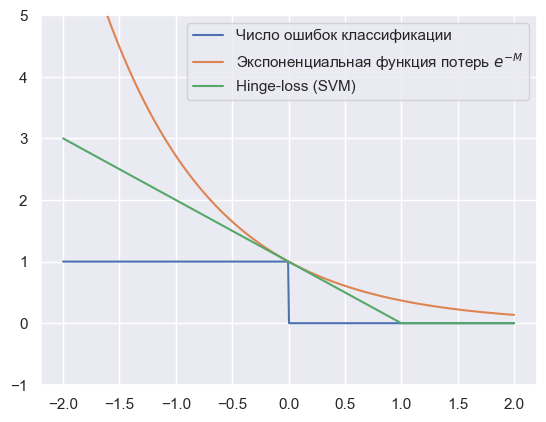

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set()

def plus(x):
    return np.where(x >= 0, x, 0)


x = np.linspace(-2, 2, 500)
error = (x <= 0).astype(np.float32)
exp = np.exp(-x)
hinge = plus(1 - x)

plt.plot(x, error, label='Число ошибок классификации')
plt.plot(x, exp, label='Экспоненциальная функция потерь $e^{-M}$')
plt.plot(x, hinge, label='Hinge-loss (SVM)')

plt.ylim((-1, 5))
plt.legend()

## Формальная постановка
Функционал качества:
$$
    Q(X, a, y) = \sum_{i=1}^N [y_i \neq a(X_i)] = \sum_{i=1}^N [\sign y_ia(X_i) < 0]
$$

Алгоритм $a(X)$ — композиция базовых алгоритмов $b_i(X)$ c весами

$$
    a(X) = \sign \sum_{i=1}^T w_ib_i(X)
$$

## Идея

Строим композицию алгоритов $b(X) = \sum_{i=1}^T w_i b_i(X)$
Последовательно строим очередной алгоритм $b_i$, зафиксировав все предыдущие с весами

1. Обучаем базовый алгоритм на всей выборке.
2. Перезвешиваем объекты из выборки таким образом, чтобы объекты, на которых алгоритм сильнее ошибается, получили больший вес.
3. Обучаем очередной классификатор на перезвешенной выборке, добавляем его к остальным с некоторыми весом.
4. Переходим на шаг 2, если качество еще не достаточно высокое.

## Вопросы:
1) Как перевзвешивать?
1) Как выбирать вес?

## AdaBoost
Предложен Freund, Shapire в конце 90-ых и начале 2000-ых. 
Хорошо изучен, имеет теоретические гарантии.

Заменяем функцию ошибок на экспоненцильную функцию $e^{-M}$. Поскольку она всюду неменьше, чем исходная, получаем
$$
    Q(X, a, y) = \sum_{i=1}^N [y_i \neq a(X_i)] = \sum_{i=1}^N [\sign y_ia(X_i) < 0] \leq
    \sum_{i=1}^{N} e^{-y_ia(X_i)} = \tilde{Q}(X, a, y).
$$

Поскольку мы зафиксировали вме предыдщие алгоритмы, то надо подбирать вес только для последнего шага.
$$a(X) = \sum_{j=1}^T w_j a_j(X) = C + w_Ta_T(X)$$


$$\tilde{Q}(X, a, y) = \sum_{i=1}^N e^{-{y_i (C + w_Ta_T(X))}} \sum_{i=1}^N e^{-y_iC} e^{-w_Ta_T(X)}
= \sum_{i=1}^N w_i^{(T - 1)} e^{-w_Ta_T(X)},$$
то есть это исходный функционал, но на перевзвешенной выборке.


### Теорема Freund-Schapire

Осталось одна проблема: какие выбрать $w_t$ для достижения наилучшей композиции в нашем процессе?
На этот вопрос умеет отвечать теорема Freund-Schapire:

Введем 2 обозначения:
   * $P(b, U) = \sum_{i=1}^{N}u_i[b(x_i) = y_i]$ - взвешанное количество верных ответов алгоритма $b$ на данных $(X, y)$
   * $N(b, U) = \sum_{i=1}^{N}u_i[b(x_i) \neq y_i]$ - взвешанное количество ошибок алгоритма $b$ на данных $(X, y)$


**Теорема (Freund, Schapire).**
Пусть для любого нормированного вектора весов $U$ существует алгоритм $b \in \mathcal{B}$, классифицирующий выборку хотя бы немного лучше, чем наугад: $P(b, U)> N(b, U)$.

Тогда минимум функционала $\tilde{Q}_T$ достигается при
$$b_T = \argmin\limits_{b\in \mathcal{B}}N(b, U)$$
$$\alpha_T = \frac{1}{2}\ln\frac{1 - N(b_T, U)}{N(b_T, U)}$$


### Проблемы AdaBoost: 
1) Чувствителен к выбросам: если для какого объекта $M$ слшиком большое по модулю и отрциальное, то его вес $e^{M}$ заглушит все остальные
2) Неинтерпритируемость модели (относится ко всем бустингам)
3) Не получается строить поверх сильных классификаторов, чаще всего строится поверх деревьев

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble._weight_boosting import (
    BaseWeightBoosting, 
    is_regressor, 
    _check_sample_weight, 
    check_random_state,
)
from sklearn.tree import DecisionTreeClassifier


old_fit = BaseWeightBoosting.fit


# this is a slightly modified copy of fit method of BaseWeightBoosting class
def fit(self, X, y, sample_weight=None):
    """Build a boosted classifier/regressor from the training set (X, y).

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The training input samples. Sparse matrix can be CSC, CSR, COO,
        DOK, or LIL. COO, DOK, and LIL are converted to CSR.

    y : array-like of shape (n_samples,)
        The target values.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If None, the sample weights are initialized to
        1 / n_samples.

    Returns
    -------
    self : object
        Fitted estimator.
    """
    X, y = self._validate_data(
        X,
        y,
        accept_sparse=["csr", "csc"],
        ensure_2d=True,
        allow_nd=True,
        dtype=None,
        y_numeric=is_regressor(self),
    )
    

    sample_weight = _check_sample_weight(
        sample_weight, X, np.float64, copy=True, only_non_negative=True
    )
    
    ########## THIS IS PATCH ##########
    self.sample_weigths = [sample_weight.copy()]
    ########## END OF PATCH ##########
    sample_weight /= sample_weight.sum()
    
    # Check parameters
    self._validate_estimator()

    # Clear any previous fit results
    self.estimators_ = []
    self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float64)
    self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float64)

    # Initialization of the random number instance that will be used to
    # generate a seed at each iteration
    random_state = check_random_state(self.random_state)
    epsilon = np.finfo(sample_weight.dtype).eps

    zero_weight_mask = sample_weight == 0.0
    for iboost in range(self.n_estimators):
        # avoid extremely small sample weight, for details see issue #20320
        sample_weight = np.clip(sample_weight, a_min=epsilon, a_max=None)
        # do not clip sample weights that were exactly zero originally
        sample_weight[zero_weight_mask] = 0.0

        # Boosting step
        sample_weight, estimator_weight, estimator_error = self._boost(
            iboost, X, y, sample_weight, random_state
        )

        # Early termination
        if sample_weight is None:
            break
        self.estimator_weights_[iboost] = estimator_weight
        self.estimator_errors_[iboost] = estimator_error

        # Stop if error is zero
        if estimator_error == 0:
            break

        sample_weight_sum = np.sum(sample_weight)
        
        ########## THIS IS PATCH ##########
        self.sample_weigths.append(sample_weight.copy())
        ########## END OF PATCH ##########

        if not np.isfinite(sample_weight_sum):
            warnings.warn(
                (
                    "Sample weights have reached infinite values,"
                    f" at iteration {iboost}, causing overflow. "
                    "Iterations stopped. Try lowering the learning rate."
                ),
                stacklevel=2,
            )
            break

        # Stop if the sum of sample weights has become non-positive
        if sample_weight_sum <= 0:
            break

        if iboost < self.n_estimators - 1:
            # Normalize
            sample_weight /= sample_weight_sum

    return self


BaseWeightBoosting.fit = fit
# AdaBoostClassifier.fit = fit

/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/148545266.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/148545266.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/148545266.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/148545266.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/148545266.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/14854

Text(0.5, 0.98, 'Decision Boundary')

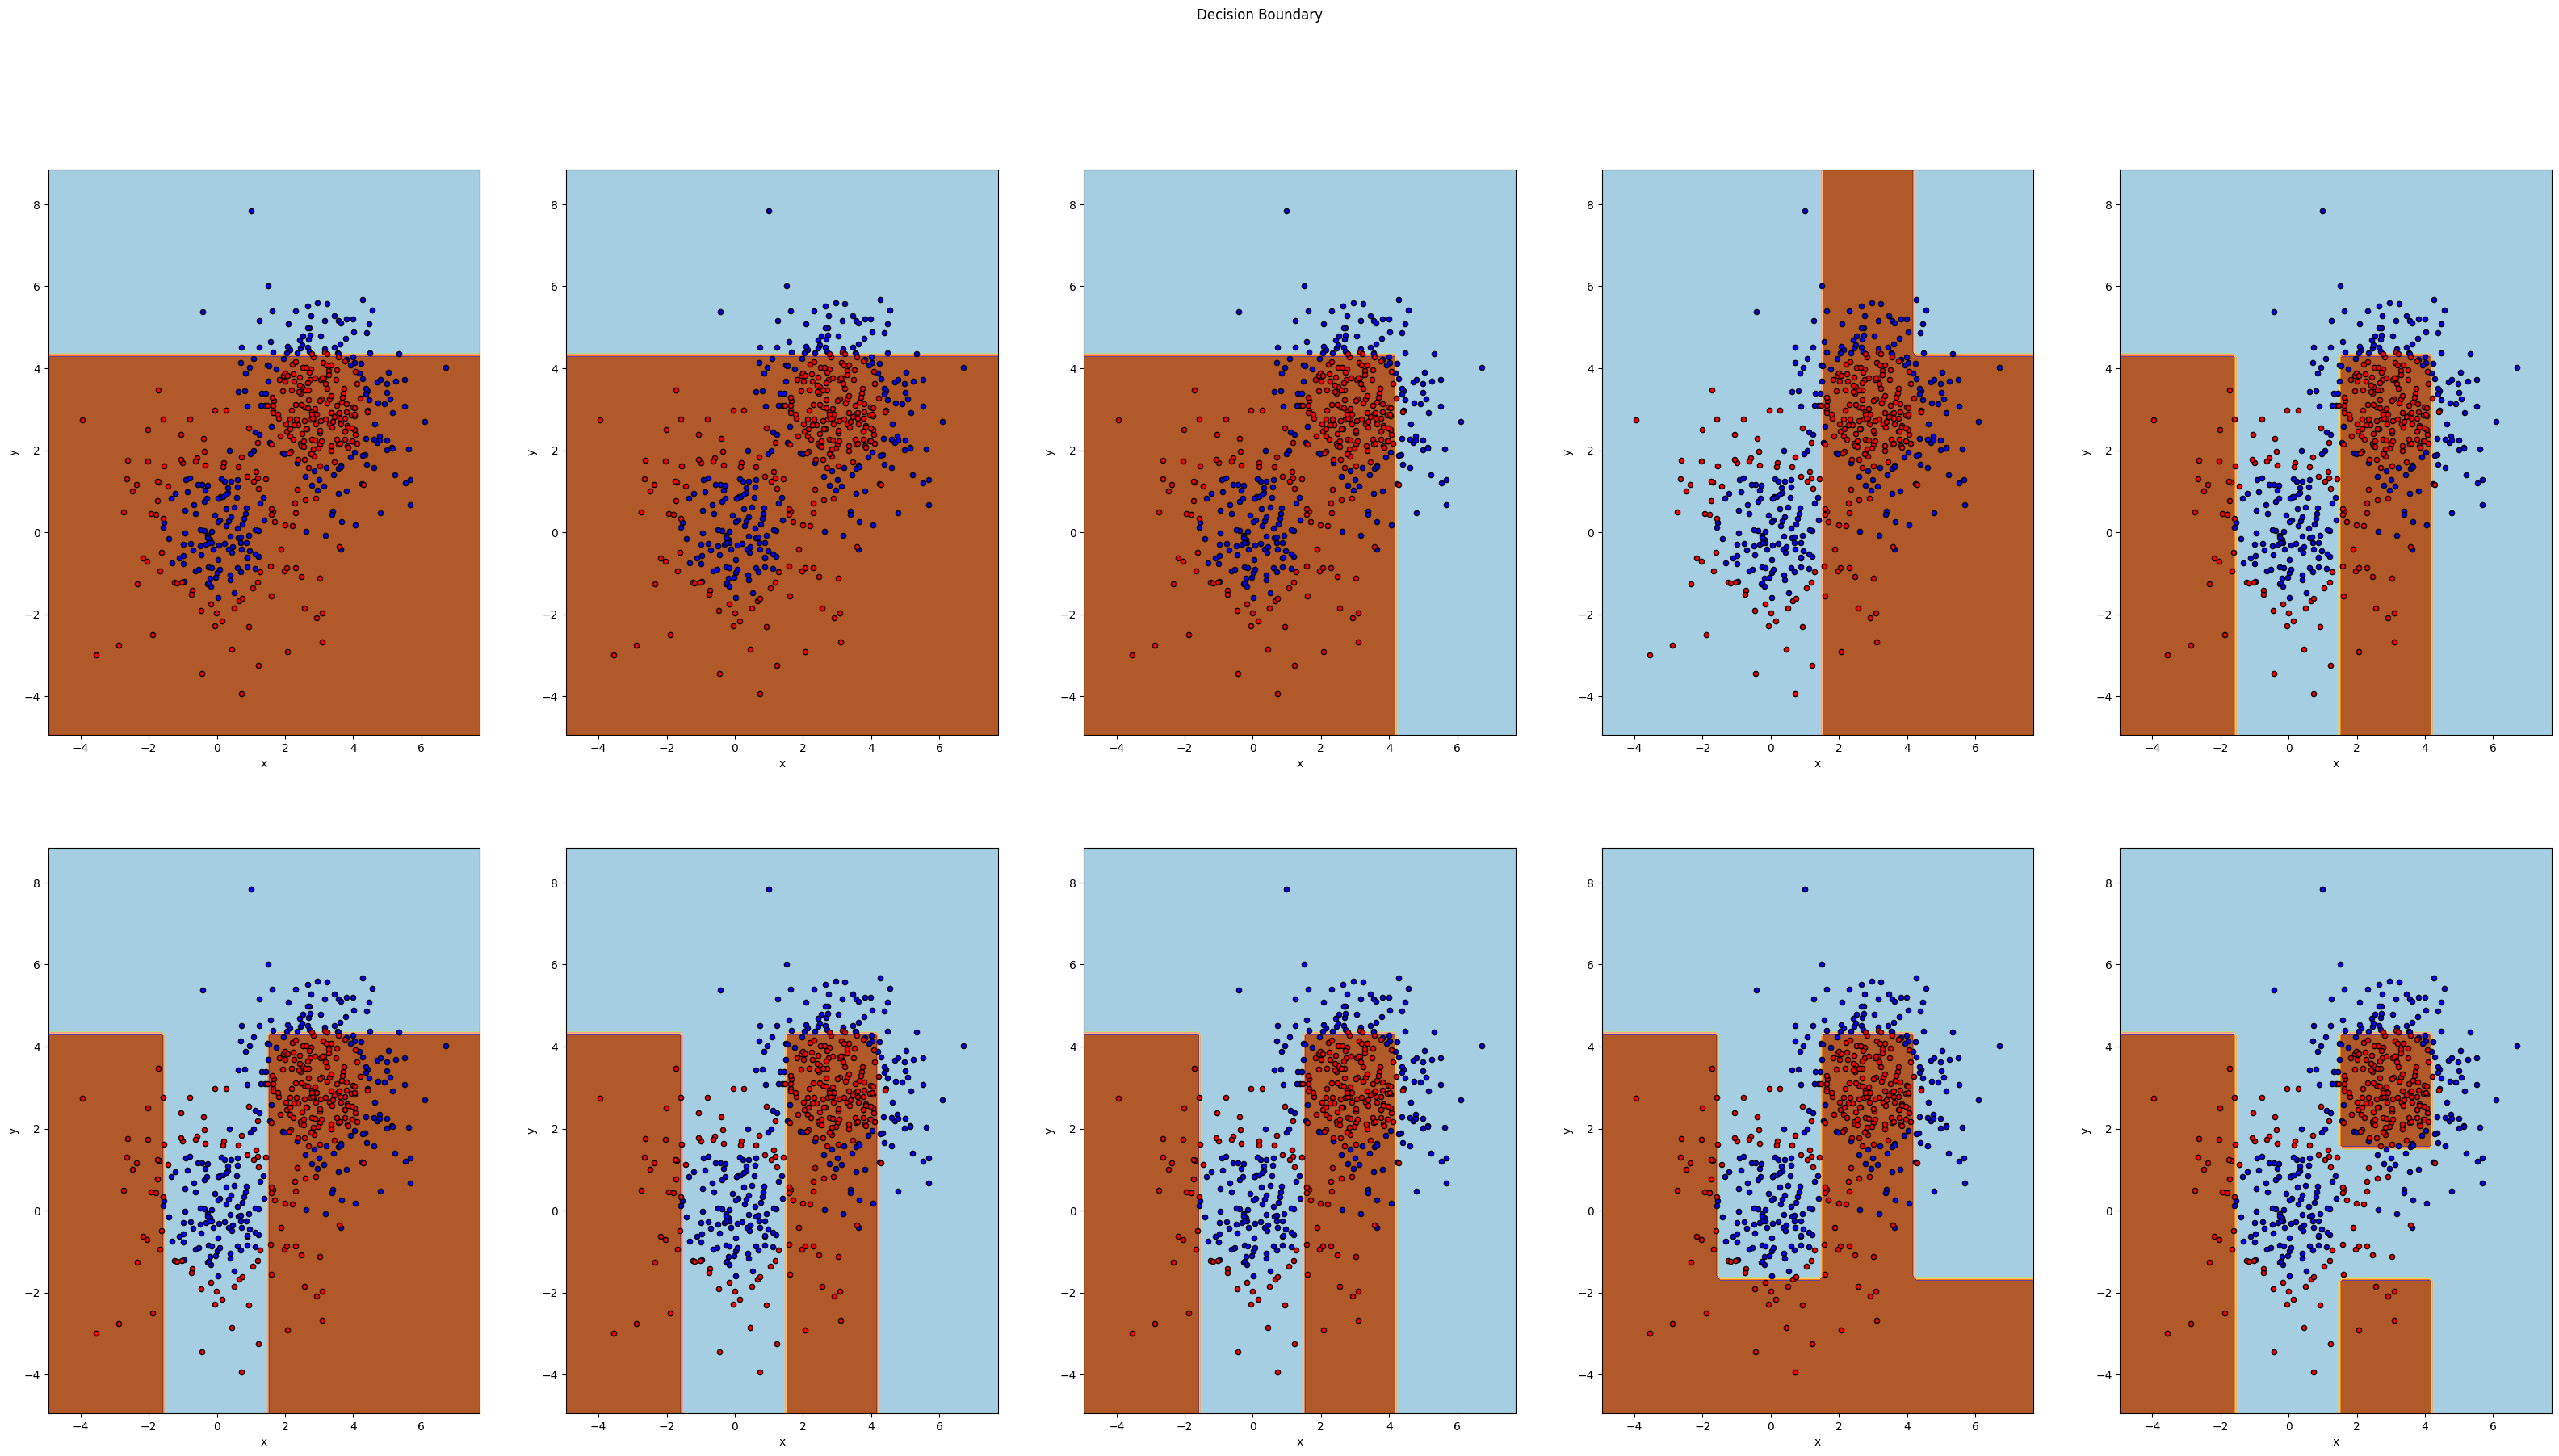

In [129]:
import numpy as np

from sklearn.base import clone
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier


def shrink_adaboost(boosting: AdaBoostClassifier, n_estimators: int) -> AdaBoostClassifier:
    new_boosting = clone(boosting)
    new_boosting.set_params(n_estimators=n_estimators)
    new_boosting.estimators_ = boosting.estimators_[:n_estimators]
    new_boosting.estimator_weights_ = boosting.estimator_weights_[:n_estimators]
    new_boosting.n_classes_ = boosting.n_classes_
    new_boosting.classes_ = boosting.classes_
    
    return new_boosting

# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

n_estimators = 10

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    algorithm="SAMME",
    n_estimators=n_estimators,
)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

# plt.figure(figsize=(10, 5))

# Plot the decision boundaries
fig, axes = plt.subplots(2, n_estimators // 2, figsize=(40, 20))
for i in range(n_estimators):
    ax = axes[i // 5][i % 5]
    shrank = shrink_adaboost(bdt, i + 1)
    disp = DecisionBoundaryDisplay.from_estimator(
        shrank,
        X,
        cmap=plt.cm.Paired,
        response_method='predict',
        plot_method='contourf',
        ax=ax,
        xlabel='x',
        ylabel='y',
    )
    x_min, x_max = disp.xx0.min(), disp.xx0.max()
    y_min, y_max = disp.xx1.min(), disp.xx1.max()

    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        ax.scatter(
            X[idx, 0],
            X[idx, 1],
            c=c,
            cmap=plt.cm.Paired,
            s=20,
            edgecolor="k",
            label="Class {}".format(n),
        )
        
    ax.set_xlim(xmin=x_min, xmax=x_max)
    ax.set_ylim(ymin=y_min, ymax=y_max)


fig.suptitle("Decision Boundary")

In [62]:
all_weights = np.array(bdt.sample_weigths)
all_weights /= all_weights.sum(axis=1, keepdims=True)

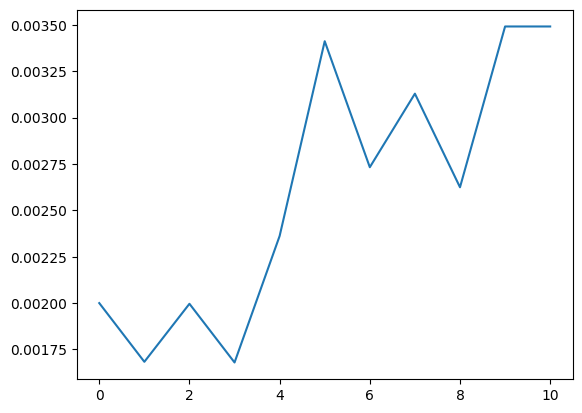

In [128]:
plt.plot(all_weights[:, 110])

In [115]:
from sklearn.preprocessing import Normalizer

/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/803668135.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/803668135.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/803668135.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/803668135.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/803668135.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/var/folders/t5/c3yltvc972g3t317t52mvtl00000gq/T/ipykernel_41730/80366

Text(0.5, 0.98, 'Decision Boundary')

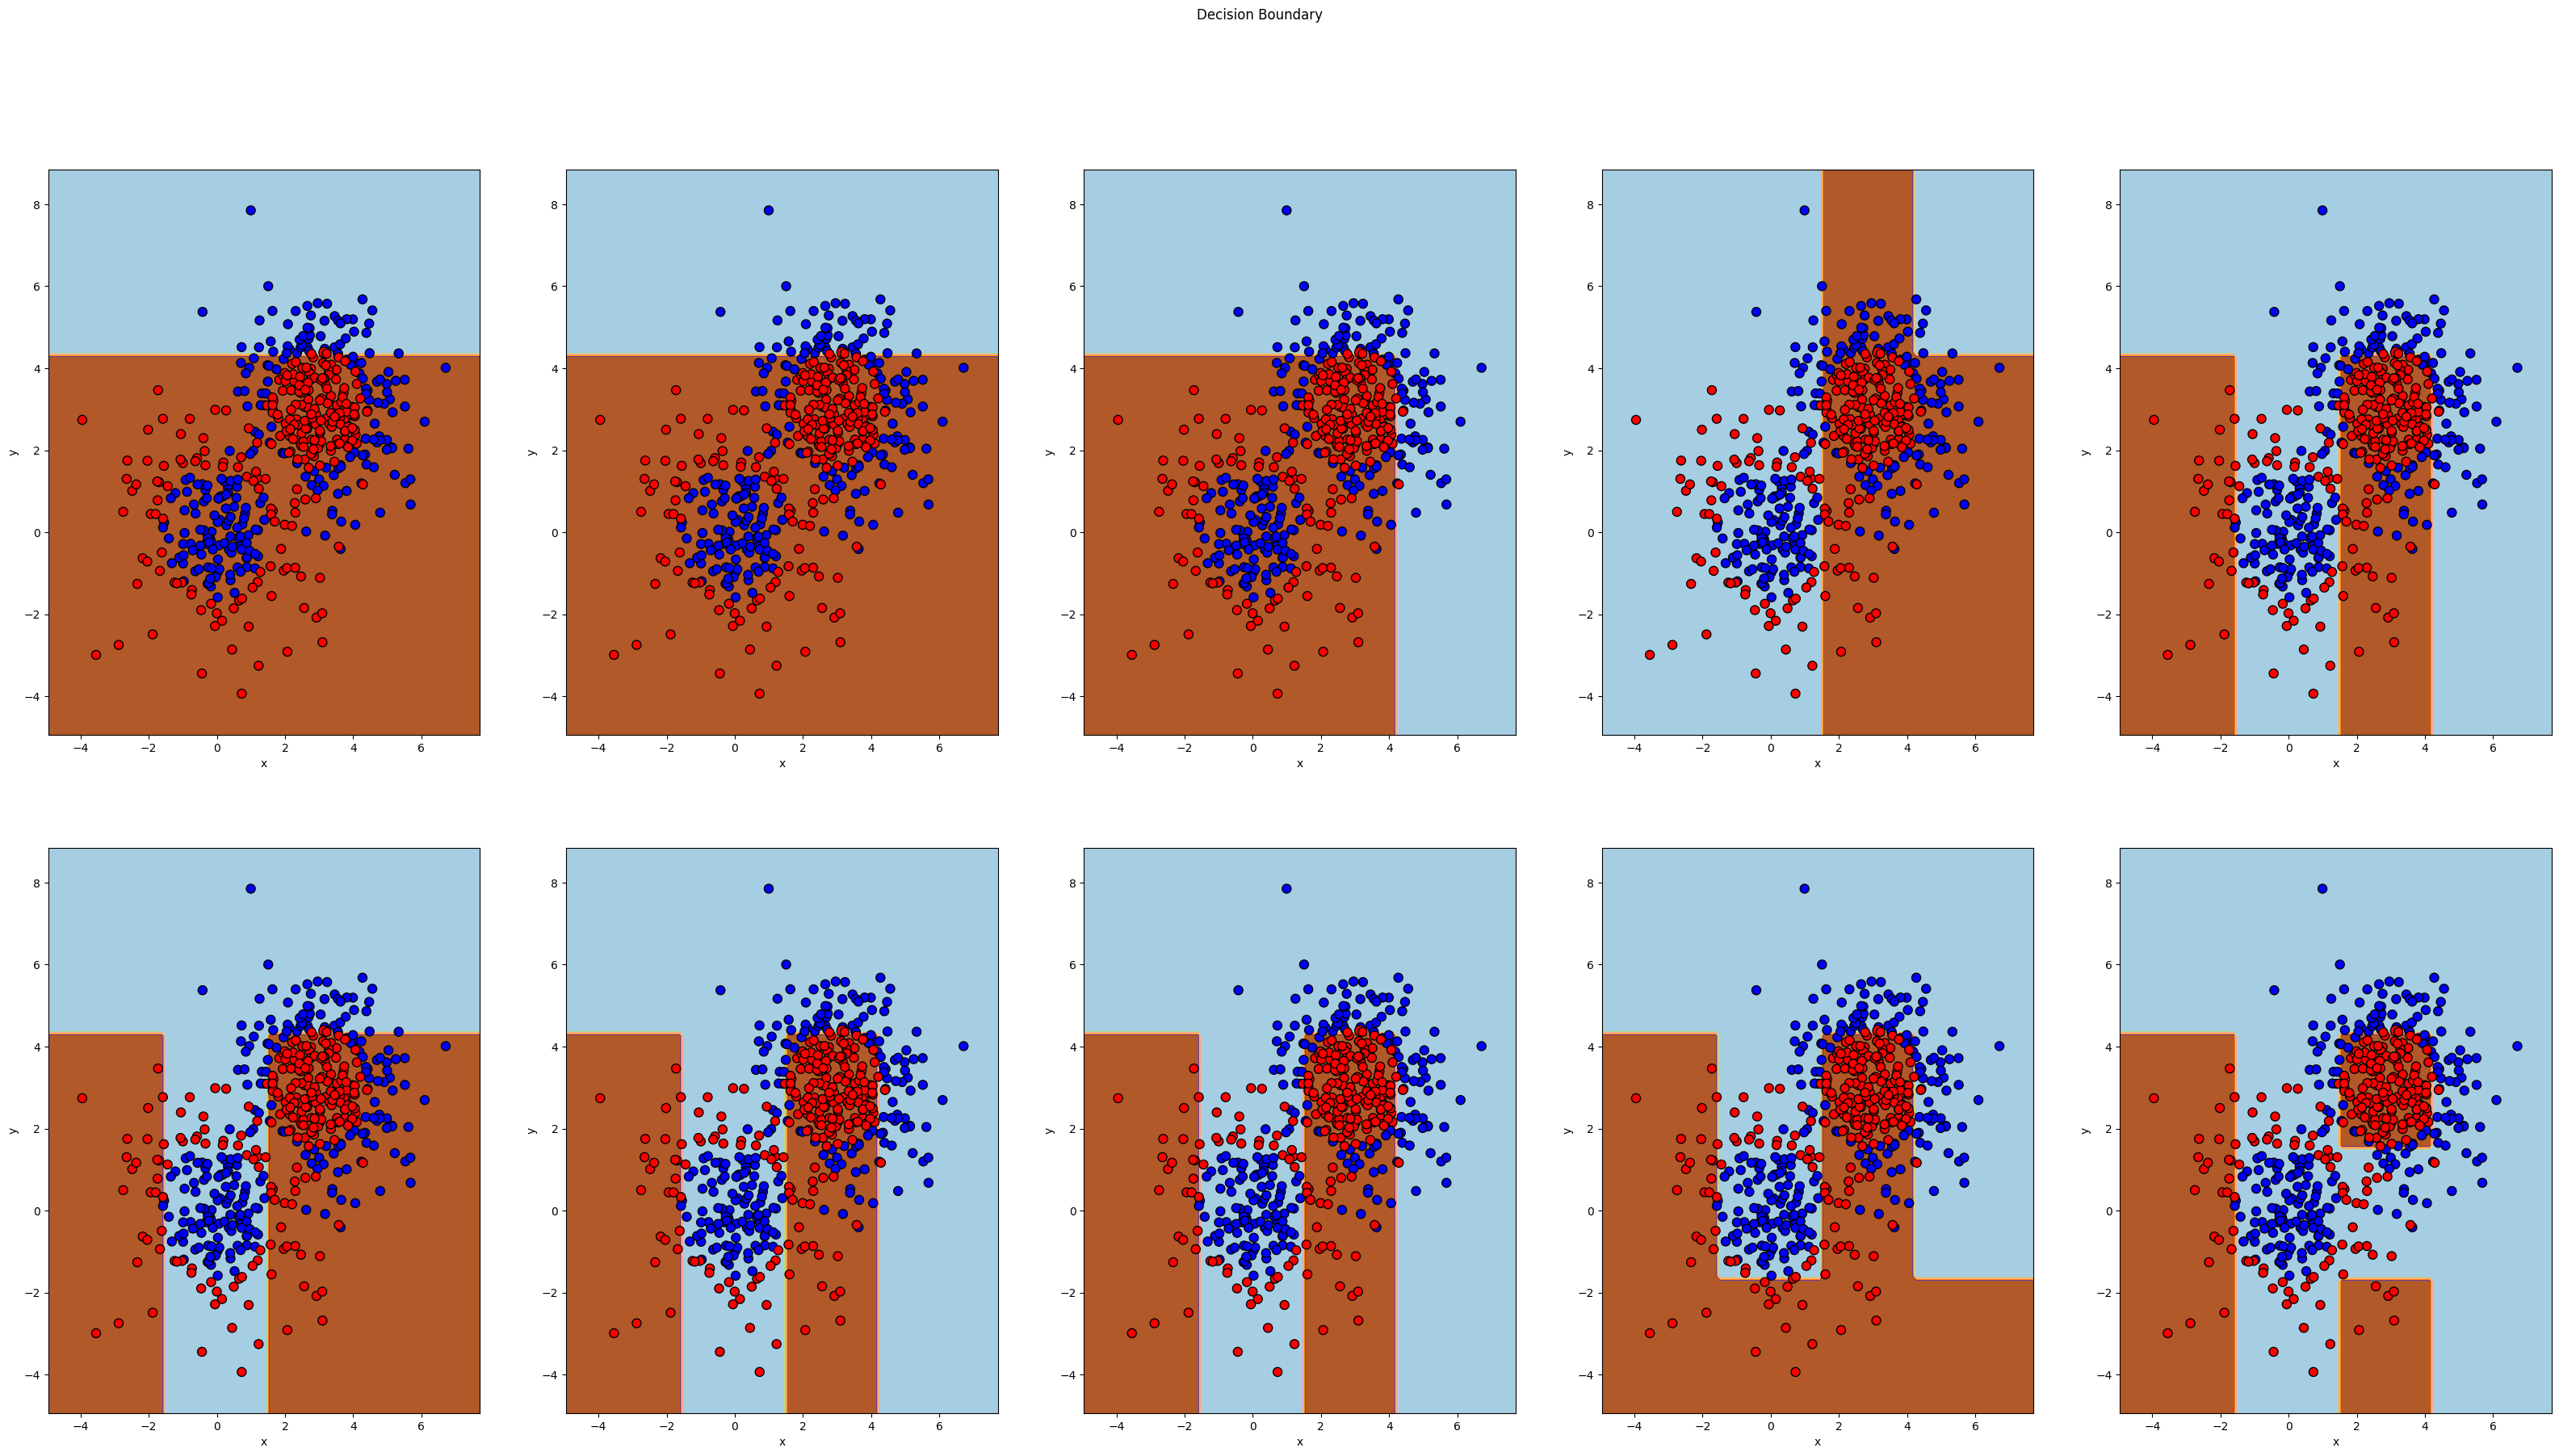

In [127]:
fig, axes = plt.subplots(2, n_estimators // 2, figsize=(40, 20))
for i in range(n_estimators):
    ax = axes[i // 5][i % 5]
    shrank = shrink_adaboost(bdt, i + 1)
    disp = DecisionBoundaryDisplay.from_estimator(
        shrank,
        X,
        cmap=plt.cm.Paired,
        response_method='predict',
        plot_method='contourf',
        ax=ax,
        xlabel='x',
        ylabel='y',
    )
    x_min, x_max = disp.xx0.min(), disp.xx0.max()
    y_min, y_max = disp.xx1.min(), disp.xx1.max()

    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        ax.scatter(
            X[idx, 0],
            X[idx, 1],
            c=c,
            cmap=plt.cm.Paired,
            s=Normalizer().fit_transform(all_weights[[i], idx])[0] * 1000,
            edgecolor="k",
            label="Class {}".format(n),
        )
        
    ax.set_xlim(xmin=x_min, xmax=x_max)
    ax.set_ylim(ymin=y_min, ymax=y_max)


fig.suptitle("Decision Boundary")

## Градиентный бустинг

### Градиентный спуск
Градиентный спуск — это итеративный численный метод поиска минимума функции.
Требуется, чтобы у функции был градиент.

$$
    y = f(w) \to \min\limits_{w}
$$

1. Инициализируем вектор $w_0$.
2. Пока не достингут критерий остановки 
    $$w_{t+1} = w_t - \lambda \grad f(x)|_{x=w_t}$$
    
    
$\lambda$ — темп обучения, может быть: 
- константным;
- зависить от шага обучения;
- подбираться на каждом шаге таким образом, чтобы значение функции было минимальным в новом векторе неизвестных.


### Один шаг бустинга
$$
    f_{t+1}(x) = f_t(x) + \alpha_ib_{t+1}(x)
$$

### Идея
Давайте приближать вектор андиградиента. Формально, пусть $g_i = \grad f(x)_{x=x_i}$, 
решаем задачу
    $$ b_{t+1} = \argmin_{b} \sum\limits_{i=1}^N (b(x_i) + g_i)^2$$.
    
    
### Алгоритм формально
**Вход:** обучаяющая выборка $X={x_1, \ldots, x_l}$, функция потерь $\mathcal{L}$

**Выход:** базовые алгоритмы и их веса $\alpha_t$, $b_t$, $t=1,2, \ldots, T$.

1. Инициалзируем: $f_i = 0, i = 1, 2, \ldots, l$.
2. для всех $t = 1, 2, \ldots, l$:
    - ищем очередной базовый алгоритм 
        $$b_{t} = \argmin_{b} \mathcal{L}(f_i, y_i)^2$$

    - ищем вес, решая задачу одномерной оптимизации
        $$
            \alpha_t = \argmin_{\alpha > 0} \sum_{i=1}^l \mathcal{L}(f_i + \alpha b_t(x_i), y_i) 
        $$
    - обновляем 
        $$
            f_{i} = f_i + \alpha_tb_t(x_i), i = 1, 2, \ldots, l.
        $$
        

### Замечения
1) Можно применять для любой функции потерь, если у нее есть градиент
2) Можно использовать методы оптимизации более выского порядка (например, метод Ньютона), если у функции есть соответствующие производные
3) Можно брать подвыборку для обучения и подмножетсво признаков — стохастическй градиентный спуск. Это
    - улучшает сходимость
    - ускоряет
    - улучшает качество
    
    
Один самых популярных базовых алгоритмов — это решающее дерево.
(S)GBDT — (Stochastic) Gradient Boosting Decision Tree

## Random Forest vs GDBT
1) Лес не переобучается при большом числе деревьев, в отличии от бустинга
2) Как правило, в лесу деревья глубже, потому что нужно сделать маленький bias

## XGBoost
Одна из самых популярных библиотек для GDBT. Много соревнований на Kaggle было выиграно с ее помощью.
1) Поддерживает регуляризацию для деревьев
2) Очень быстрая, в том числе позволяет использовать GPU
3) Обрабатывает пропуски
4) Поддерживает большое число функций потерь: для классфикации, регрессии и ранжирования.

## CatBoost
Бытсрая библиотека для GDBT. 
1) Поддерживает регуляризацию для деревьев
2) Очень быстрая, в том числе позволяет использовать GPU
3) Обрабатывает пропуски
4) Поддерживает большое число функций потерь: для классфикации, регрессии и ранжирования.
5) Использует Oblivious Decision Trees.
6) Много трюков для обработки категориальных данных

## Параметры, которые надо перебирать у градиентного бустинга
1) темп обучения
2) коэффициенты регуляризации

## Ссылки
1. [Слайды](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) лекции К. В. Воронцова про композиции алгоритмов (2018 год)
2. [AdaBoost-SAMME](https://hastie.su.domains/Papers/samme.pdf) — реализация AdaBoost в Scikit-Learn. Zhu, H. Zou, S. Rosset, T. Hastie, “Multi-class AdaBoost”, 2009.